In [12]:
import numpy as np 
from PIL import Image 
from matplotlib import pyplot as plt 
import cv2 
import tensorflow_datasets as tfds
import tensorflow as tf 
import os 
os.chdir(r'/kaggle/input/unet-utils')
from model_archt import * 
#from model_softmax import *  
#from model_funct import * 

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3AU2JE/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3AU2JE/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
def data_preprocessing(dataset_):
    out_size=160
    
    inp_img=dataset_['image']
    inp_mask=dataset_['segmentation_mask']
    #first resixe the image 
    inp_img=tf.image.resize(inp_img,(out_size,out_size),method='nearest')
    inp_mask=tf.image.resize(inp_mask,(out_size,out_size),method='nearest')
    
    #normalizing the value 
    inp_img=inp_img/255
    inp_img = tf.cast(inp_img,tf.float32)
    
    
    # setting the right value for the label image 
    inp_mask= inp_mask%2 
    inp_mask = tf.cast(inp_mask,tf.float32)

    
    #now augmenting the data 
    inp_img=tf.image.flip_left_right(inp_img)
    inp_mask=tf.image.flip_left_right(inp_mask)  
    return inp_img,inp_mask
    
    
    

In [4]:
train_dataset = dataset["train"].map(data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
train_batches = train_dataset.cache().shuffle(1000).take(3000).batch(30)
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [35]:
len(train_batches)

100

In [6]:
train_img,train_mask=iter(train_batches).get_next()


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [29]:
train_img.shape

TensorShape([30, 160, 160, 3])

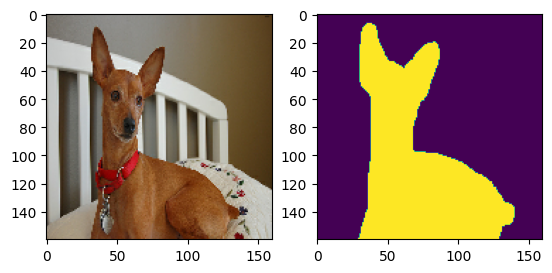

In [7]:
n=25
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(train_img[n])
ax[1].imshow(train_mask[n])
plt.show()

In [8]:
validation_batches = test_dataset.take(3000).batch(30)
#test_batches = test_dataset.skip(3000).take(669).batch(20)

In [9]:
ori_validation_img=iter(validation_batches).get_next()[0]
ori_validation_mask=iter(validation_batches).get_next()[1]

In [16]:
inp_img=[]
inp_mask=[]
input_shape_=160
for num,i in enumerate(dataset['train']):
    
    inp_img.append(tf.image.resize(i['image'], (input_shape_, input_shape_), method='nearest'))
    inp_mask.append(tf.image.resize(i['segmentation_mask'], (input_shape_, input_shape_), method='nearest'))
    if num == 200-1:
        break 
    
inp_img = np.array(inp_img)/255
inp_mask = np.array(inp_mask)

In [17]:
inp_mask[inp_mask == 2] = 0
inp_mask[inp_mask == 1] = 1
inp_mask[inp_mask == 3] = 1

In [18]:
inp_img = inp_img.astype(np.float32)
inp_mask = inp_mask.astype(np.float32)

In [19]:
inp_aug_img=[]
inp_aug_mask=[]
for i,_ in enumerate(inp_img):
    inp_aug_img.append(tf.image.flip_left_right(inp_img[i]))
    inp_aug_mask.append(tf.image.flip_left_right(inp_mask[i]))

inp_img=np.array(inp_aug_img)
inp_mask=np.array(inp_aug_mask)
del inp_aug_img 
del inp_aug_mask

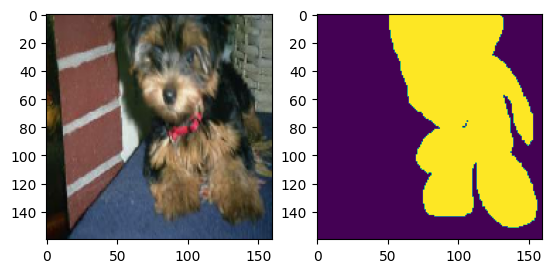

In [93]:
indx=np.random.randint(0,200)
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(inp_img[indx])
ax[1].imshow(inp_mask[indx])
plt.show()

In [10]:
input_shape_=160
model = u_net_model(is_train=True,inp_shape=(input_shape_,input_shape_,3))

In [11]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
out=model(np.random.randn(1,160,160,3),np.random.randn(1,160,160,1))

2024-03-22 06:58:56.378785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [13]:
model.load_weights(r'final_modelweights.weights.h5')

In [24]:
#divide into batches
num_of_batch=10
inp_img_batch=inp_img.reshape((num_of_batch,20,input_shape_,input_shape_,3))
inp_mask_batch=inp_mask.reshape((num_of_batch,20,input_shape_,input_shape_,1))

In [20]:
# Define your learning rate schedule function
def lr_schedule(epoch,initial_learning_rate):
    """
    Returns a custom learning rate that decreases as the training progresses.
    """

    learning_rate = initial_learning_rate
    if (epoch==15) or (epoch==40):
        learning_rate = initial_learning_rate / 10
    return learning_rate

In [21]:
epoch=60
total_loss=[]
best_loss=1 
#checkpoint_dir=r'/kaggle/working/cheekpoint'
#save_and_resume_callback = SaveAndResumeCallback(model,checkpoint_dir)
for i in range(epoch): 
    save_loss=0
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_accuracy = tf.keras.metrics.BinaryAccuracy ()
    validation_accuracy=tf.keras.metrics.BinaryAccuracy()
    for batch,dt in enumerate(train_batches):
        with tf.GradientTape()as tape:
            model.is_train=True
            loss,y_t = model(input_img=dt[0], ylabel=dt[1])
            gradients = tape.gradient(
                  loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
            #print(f' batch{batch} epoch {i} loss  {loss.numpy()}') 
        save_loss=save_loss+loss 
        if best_loss > loss:
            best_loss=loss
            model.save_weights('/kaggle/working/final_modelweights1.weights.h5')
            
        epoch_train_loss_avg.update_state(loss)
        epoch_train_accuracy.update_state(dt[1], y_t)
        # claculte validation 
        model.is_train=False 
        predicted_mask=model(input_img=ori_validation_img)
        validation_accuracy.update_state(ori_validation_mask,predicted_mask)
    new_learning_rate = lr_schedule(i,optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(new_learning_rate)
    #save_and_resume_callback.on_epoch_end(i)   
    #total_loss.append(save_loss/num_of_batch)
    print("Epoch {:03d}: Loss: {:.3f}, train Accuracy: {:.3%} , validation accuracy: {:.3%}".format(i + 1,
                                                                          epoch_train_loss_avg.result(),
                                                                          epoch_train_accuracy.result(),
                                                                        validation_accuracy.result()
                                                                                                   ))

      
     

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 001: Loss: 0.388, train Accuracy: 85.625% , validation accuracy: 81.961%
Epoch 002: Loss: 0.274, train Accuracy: 90.111% , validation accuracy: 91.352%
Epoch 003: Loss: 0.251, train Accuracy: 91.228% , validation accuracy: 91.318%
Epoch 004: Loss: 0.231, train Accuracy: 92.102% , validation accuracy: 92.629%
Epoch 005: Loss: 0.221, train Accuracy: 92.440% , validation accuracy: 93.154%
Epoch 006: Loss: 0.212, train Accuracy: 92.731% , validation accuracy: 92.516%
Epoch 007: Loss: 0.202, train Accuracy: 93.087% , validation accuracy: 92.299%
Epoch 008: Loss: 0.183, train Accuracy: 93.891% , validation accuracy: 92.872%
Epoch 009: Loss: 0.179, train Accuracy: 93.979% , validation accuracy: 92.961%
Epoch 010: Loss: 0.170, train Accuracy: 94.340% , validation accuracy: 94.287%
Epoch 011: Loss: 0.162, train Accuracy: 94.601% , validation accuracy: 93.316%
Epoch 012: Loss: 0.158, train Accuracy: 94.697% , validation accuracy: 93.853%
Epoch 013: Loss: 0.148, train Accuracy: 95.095% , va

In [17]:
model.save_weights('/kaggle/working/final_re_saving_modelweights.weights.h5')

In [2]:
input_shape_=160
model = u_net_model(is_train=False,inp_shape=(input_shape_,input_shape_,3))
out=model(np.random.randn(1,160,160,3),np.random.randn(1,160,160,1))

In [13]:
model.is_train=False
model.load_weights(r'/kaggle/working/final_re_saving_modelweights.weights.h5')

In [24]:
test_dt=test_dataset.take(100).batch(10)

In [25]:
accuracy=tf.keras.metrics.BinaryAccuracy()
for i,j in (test_dt):
    out_val=model(input_img=i)
    accuracy.update_state(j,out_val)
    
    print(accuracy.result())  

tf.Tensor(0.95721483, shape=(), dtype=float32)
tf.Tensor(0.9567812, shape=(), dtype=float32)
tf.Tensor(0.9567018, shape=(), dtype=float32)
tf.Tensor(0.95416105, shape=(), dtype=float32)
tf.Tensor(0.95551085, shape=(), dtype=float32)
tf.Tensor(0.9545012, shape=(), dtype=float32)
tf.Tensor(0.9512254, shape=(), dtype=float32)
tf.Tensor(0.951434, shape=(), dtype=float32)
tf.Tensor(0.95000863, shape=(), dtype=float32)
tf.Tensor(0.9506722, shape=(), dtype=float32)


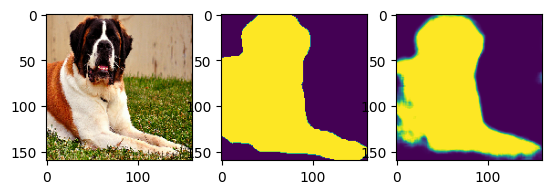

In [31]:
n=3
ori_img=iter(test_dt).get_next()[0][n:n+1]
ori_mask=iter(test_dt).get_next()[1][n]

predicted_mask=model(ori_img)
fig,ax=plt.subplots(nrows=1,ncols=3)
ax[0].imshow(ori_img[0])
ax[1].imshow(ori_mask)
ax[2].imshow(predicted_mask[0])
plt.show()

In [58]:
img1=Image.open(r'/kaggle/input/unet-utils/image_0049.jpg')

In [59]:
test_img=np.array(img1.resize((160,160)))[np.newaxis,:]/255
#test_img=test_img.astype(np.float32)

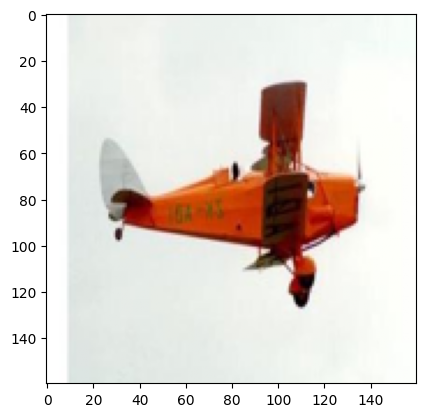

In [60]:
plt.imshow(test_img[0])
plt.show()

In [61]:
pred_mask=model(test_img)

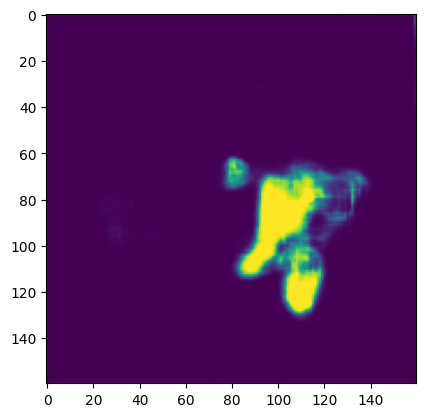

In [62]:
plt.imshow(pred_mask[0])
plt.show()